# homework 3: permutation tests

In [1]:
using DataFrames
using CSV
using PyPlot
using Random

# (optional) change the style. see styles here: 
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("bmh")                                    
                                                                                  
# (optional) change settings for all plots at once, e.g. I like larger font 
# size                           
rcParams = PyPlot.PyDict(PyPlot.matplotlib.rcParams)                           
rcParams["font.size"] = 16

# (optional) change the max width of columns of `DataFrame`
#  that are displayed in the Juptyer Notebook.
ENV["COLUMNS"] = 300; # characters

### modifying the Cavendish banana to make it more resistant to Panama disease

The Cavendish [banana is threatened](https://www.theguardian.com/science/2018/aug/05/science-search-for-a-super-banana-panama-disease-gm-gene-editing) by Panama disease, which is caused by a fungus. An active area of research is to genetically modify the Cavendish banana plant to make it resistant to Panama disease.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/9/9b/Cavendish_Banana_DS.jpg/1920px-Cavendish_Banana_DS.jpg width=200>

In this homework assignment, we have identified a gene in the banana plant, gene X, that is thought to be associated with resistance to fungal infection. Using modern gene editing tools such as CRISPR, we are able to make a precise, single-nucleotide edit to the gene X that appears in the wild. The hope is that this single nucleotide polymorphism will confer protection against fungal infection. 

To experimentally test whether a certain mutation of gene X will confer greater resistance to Panama disease, we randomly select 60 healthy banana plants from different regions/farms that have not been exposed to the fungus causing Panama disease (all free of Panama disease). Of these 60 plants, we randomly select 30 to receive the genetic mutation on gene X. We then collect one seed from all 60 plants. 

A botanist then plants each seed in a pot whose soil is known to harbor the fungus that causes Panama disease. The plants are all contained in a single greenhouse. After one year, the botanist records whether or not each grown banana plant has been infected with Panama disease. The study is "blind" because we never told the botanist which seeds are modified and which are not. This way, the botanist cannot (advertently or inadvertently) treat the two different variants of plants differently and thereby influence the outcome of the experiment in a biased manner.

(1) the results of our randomized experiment are in `banana_study.csv`. each row represents a banana plant. the `:gene_x` attribute indicates whether gene X in the banana plant is the wild type or mutant. the `:outcome` attribute indicates the outcome of the experiment (infected or not infected). read in `banana_study.csv` as a `DataFrame`, `df`.

In [2]:
df = CSV.read(
    joinpath(
        "data",
        "banana_study.csv"
    ),
    copycols=true
)
println(size(df))
first(df, 6)

(60, 2)


,gene_x,outcome
,String,String
1,wild type,not infected
2,wild type,infected
3,wild type,not infected
4,wild type,not infected
5,wild type,not infected
6,wild type,not infected


(2) use the `by` command to group the banana plants in `df` by genetic variant and create a new `DataFrame`, `df_outcome`, with a new column, `p_infected`, that contains the proportion of plants of that variant that are infected by the fungus.

i.e. create a dataframe, `df_outcome`:
```
     gene_x      p_infected
    wild type       ...
     mutant         ...
```

In [11]:
df_outcome = by(
    df,
    :gene_x,
    p_infected=:outcome 
    => x -> sum([!occursin("not", lowercase(e)) for e in x] / length(x))
)
df_outcome

,gene_x,p_infected
,String,Float64
1,wild type,0.133333
2,mutant,0.3


(3) create a data visualization representing `df_outcome`. particularly, make a bar plot with two bars, one corresponding to wild type, the other to mutant. Then make the bar heights equal to the respective proportion of banana plants of that genetic variant that were infected by the fungus. With a different color, stack a bar *on top* of these bars to represent the proportion that were not infected. The total height of each bar (sum of the two bars of different colors, stacked on top of each other) should be 1.0 to represent the entire set of bananas falling in that group. A skeleton code is shown below as an example. properly label your x-axis, y-axis, and x-ticks, and place a legend to denote the colors.

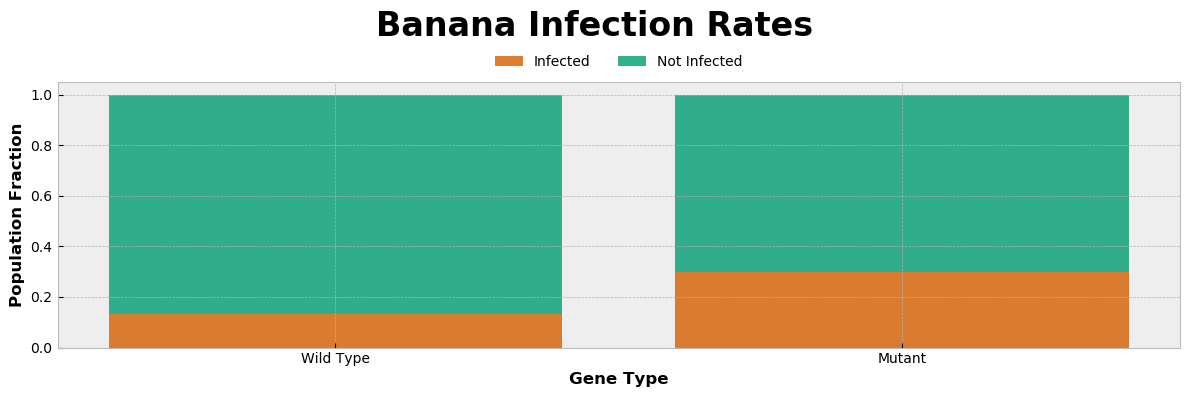

In [13]:
num_genes = size(df_outcome)[1]

(fig, ax) = subplots(1, 1, figsize=(12,4))

# https://twitter.com/bangwong/status/492662880760655873
plot_colors = Dict(
    :bad => [[213, 94, 0] / 255],
    :good => [[0, 158, 115] / 255],
)

alpha = Dict(
    :data => 0.8,
    :grid => 0.5,
)
for i in 1:num_genes
    infected_fraction = df_outcome[i, :p_infected]    
    bar(
        i,
        infected_fraction,
        color=plot_colors[:bad], 
        alpha=alpha[:data]
    )
    bar(
        i, 
        1 - infected_fraction, 
        bottom=infected_fraction,
        color=plot_colors[:good],
        alpha=alpha[:data]
    )
end
xticks(1:num_genes, [titlecase(g) for g in df_outcome[!, :gene_x]])
xlabel("Gene Type", weight="bold")
ylabel("Population Fraction", weight="bold")
legend(
    ["Infected", "Not Infected"],
    loc="upper center", 
    bbox_to_anchor=(0.5, 1.15),
    ncol=2, 
    framealpha=0
)
suptitle(
    "Banana Infection Rates", 
    weight="bold", 
    size=24
)
tight_layout()
subplots_adjust(top=0.8);

(4) Which genetic variant has the smallest proportion of infected plants? Can we conclude that this genetic variant is **certainly** more resistant to Panama disease than the other? If not, state a hypothetical but concrete reason why this outcome could be due to chance.

The wild variant has the smallest portion of infected plants, however we can not conclude that it is certainly more resistant to Panama disease because of it. This difference in infection could be caused by an uneven distribution of fungus between pots, or possibly variations in environmental conditions (temperature, humidity, airflow etc.) within the greenhouse.

(5) Formally state the null hypothesis and alternative hypothesis that pertains to this experiment.

Among the population of banana plants exposed to the fungus that causes Panama disease:

the **null hypothesis** is that the infected population fraction of mutant and wild banana genes is identical

the **alternative hypothesis** is that the infected population fraction of mutant bananas is higher than that of wild bananas

(6) Let us define and use the following test statistic, which would differ depending on whether the null or alternative hypothesis were true:

**test statistic** := (proportion of plants harboring mutant gene X that were infected) - (proportion of plants harboring wild type gene X that were infected)

(6a) write a function `proportion_infected` that takes in three arguments:
* `df_banana`, a `DataFrame` where each row is a banana, with an `:outcome` column (:infected" or "not infected") and another column indicating which variant of gene X ("wild type" or "mutant") that plant harbors. `df` from (1) is an example input argument.
* `gene_x_col_name`, a `Symbol`, the name of the column in `df_banana` that indicates which gene X variant the plants harbor ("wild type" or "mutant"). so `df_banana[1, gene_x_col_name]` gives us the variant of banana 1.
* `gene_x`, a `String`, that can be either "wild type" or "mutant"

and returns the proportion of banana plants harboring `gene_x` (`="wild type"` or `="mutant"`) gene X that were infected by fungus.

In [32]:
"""
return the proportion of banana plants infected by the fungus that harbor a 
certain gene X variant

NOTE: this would be a lot faster if I was allowed to use the dataframes I 
calculated earlier instead of re-filtering the main dataframe every time.
"""
function proportion_infected(
        df_banana::DataFrame,
        gene_x_col_name::Symbol, 
        gene_x::String
) 
        return filter(
            row -> occursin(
                lowercase(gene_x),
                lowercase(row[gene_x_col_name])
            ),
            by(df_banana, gene_x_col_name, p_infected=:outcome => x -> 
                sum([!occursin("not", lowercase(e)) for e in x] / length(x))
            )
        )[1, :p_infected]

end

proportion_infected

(6b) write a function `difference_in_proportions_infected` that takes in two arguments:
* `df_banana::DataFrame` as above
* `gene_x_col_name::Symbol` as above

and returns the test statistic. Inside this function, you should call your function from (6a) directly above, twice.

compute the actual, observed (as opposed to simulated under the null hypothesis, which we will do next) test statistic of our data set using `df` from (1).

In [30]:
"""
p_wild_type := proportion of banana plants harboring wild type gene X infected by fungus
p_mutant := proportion of banana plants harboring mutant gene X infected by fungus

test statistic := p_mutant - p_wild_type.
"""
function difference_in_proportions_infected(
    df_banana::DataFrame,
    gene_x_col_name::Symbol
)
    return proportion_infected(
        df_banana, 
        gene_x_col_name, 
        "mutant"
    ) - proportion_infected(
        df_banana, 
        gene_x_col_name, 
        "wild"
    )
end

test_statistic = difference_in_proportions_infected(df, :gene_x);

(7) imagine we are at the beginning of the experiment where we selected 60 banana plants. at this point, we are randomly selecting which banana plants receive the genetic modification on gene X and which do not. now, simulate one repetition of the banana study, **operating under the assumption that the null hypothesis is true**, by permuting the labels in the `gene_x` column of `df`. this effectively simulates the random allocation of healthy banana plants to the two groups:
* group A: do not receive genetic modification on gene X (wild type)
* group B: receive genetic modification on gene X (mutant)

assume that the botanist plants these banana plant seeds in exactly the same pots in the greenhouse. in this conceptual experiment, the outcome (infected vs. not) would be exactly the same **if the null hypothesis were true**, since then the genetic modification makes no difference in susceptibility to fungal infection. assign the permuted labels to be a new column in `df` called `:shuffled_gene_x`.

In [33]:
df[!, :shuffled_gene_x] = shuffle(df[!, :gene_x])
first(df, 6)

,gene_x,outcome,shuffled_gene_x
,String,String,String
1,wild type,not infected,mutant
2,wild type,infected,wild type
3,wild type,not infected,mutant
4,wild type,not infected,mutant
5,wild type,not infected,mutant
6,wild type,not infected,wild type


(8) **operating under the assumption that the null hypothesis is true:**

(8a) simulate 10,000 repetitions of the randomized banana experiment. keep track of the test statistic observed from each simulation. 

(8b) plot the distribution of the test statistic. make your bins for the histogram manually to ensure the bin that includes zero is centered at zero. draw a red, vertical line at the actual test statistic observed in the experiment. the mean value of the test statistic should be around zero. make sure you understand why.

(8c) compute the p-value associated with our null hypothesis that you obtained from your **random permutation test**.

(8d) precisely explain in a few sentences or less what this p-value represents.

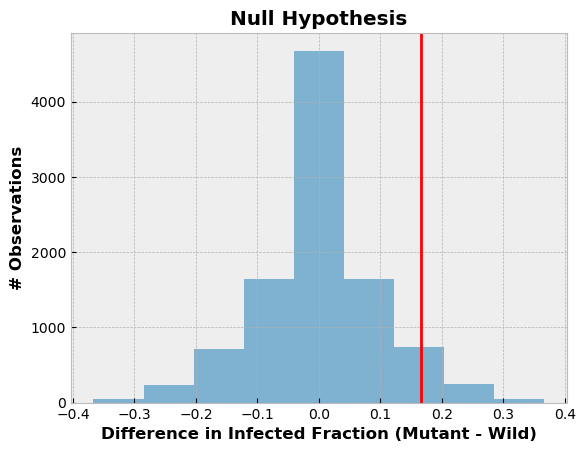

p = 0.1034

In [58]:
num_sims = 10000
test_stats = [NaN for _ in 1:num_sims]
for i in 1:num_sims
    df[!, :shuffled_gene_x] = shuffle(df[!, :gene_x])
    test_stats[i] = difference_in_proportions_infected(df, :shuffled_gene_x)
end

bin_max = maximum(broadcast(abs, test_stats))
bins = range(-bin_max, stop=bin_max, length=10)

a = hist(test_stats, bins=bins, alpha=0.6)
axvline(test_statistic, color="r")
xlabel("Difference in Infected Fraction (Mutant - Wild)", weight="bold")
ylabel("# Observations", weight="bold")
title("Null Hypothesis", weight="bold")

p = sum(test_stats .>= test_statistic) / num_sims
print("p = $p")

what is the p-value in this context? 

In the context of this test the p-value represents the probability that the infection rates are actually identical, and the difference in infection that we observed between genetic variants in the original data set was due to random chance.

(9) if the level of significance is set at $\alpha=0.05$, you may have the tendency to make a bold conclusion, such as "mutating gene X confers resistance to fungal infection" or "mutating gene X does not influence the susceptibility to fungal infection". however, such "dichotomization" is a mis-interpretation of the p-value. we must embrace uncertainty! see [this recent article in Nature](https://www.nature.com/articles/d41586-019-00857-9) where, owing to the tendency to misinterpret p-values, some scientists call for abandoning the notion of statistical significance.

> "We are calling for a stop to the use of P values in the conventional, dichotomous way -- to decide whether a result refutes or supports a scientific hypothesis" [source](https://www.nature.com/articles/d41586-019-00857-9)


## warning
it is very easy to follow the steps and permute the labels in the `:gene_x` column without understanding *why*. please make sure to think carefully about why you can permute the labels to simualte the experiment under the null hypothesis. also think about why you cannot simulate the experiment under the alternative hypothesis.

## random note on bananas
for those interested, [here](https://www.youtube.com/watch?v=YkI3zkQ4WBo&t) is an interesting, 20-minute YouTube documentary on the banana and how it is threatened by Panama disease.